# Local speed regression

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import importlib
import pandas
import os
import cv2
import sklearn.svm as svm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.externals import joblib
import numpy as np
from speed_regression import training_data as td

from scipy.ndimage.filters import gaussian_filter1d
nano_to_sec = 1e09

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 8

Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0


<IPython.core.display.Javascript object>


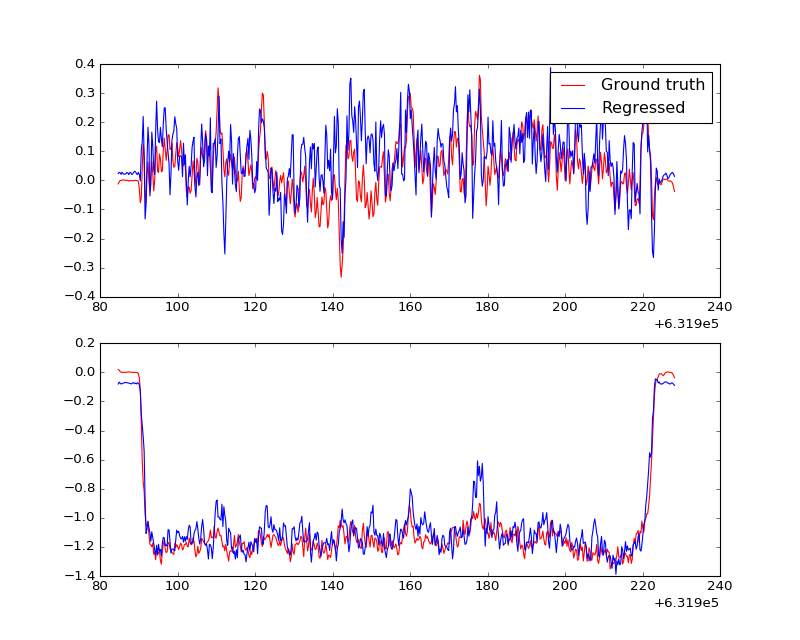

Channel  0
Loading  ../../models/SVR_0914_small_w200_s10_0.yml
Score: 0.00956691609108
Channel  2
Loading  ../../models/SVR_0914_small_w200_s10_2.yml
Score: 0.00964259315136


In [7]:
data_all = pandas.read_csv('../../data2/hang_handheld_normal2/processed/data.csv')
time_stamp = data_all['time'].values / nano_to_sec

imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

option = td.TrainingDataOption(window_size=200, sample_step=50, feature='direct_gravity', target='local_speed_gravity')
sample_points = np.arange(option.window_size_, time_stamp.shape[0] - 1, option.sample_step_, dtype=int)

extra_args = {'target_smooth_sigma': 30.0,
             'feature_smooth_sigma': 2.0}

test_feature_gravity, test_target_gravity = td.get_training_data(data_all=data_all, imu_columns=imu_columns,
                                                                sample_points=sample_points,
                                                                option=option, extra_args=extra_args)


sub_ind = 0
lw = 1.0
font = {'family': 'serif', 'size': 18}
# plt.rc('font', **font)
plt.figure('With gravity')
for i in [0, 2]:
    print('Channel ', i)
    # model_path = '../../models/model_direct_local_speed_w400_s10_small.svm_{}'.format(i)
    model_path = '../../models/SVR_0914_small_w200_s10_{}.yml'.format(i)
    # model_path = 'speed_regression/model_test_cv_{}_cv.yml'.format(i)
    with open(model_path) as f:
        print('Loading ', model_path)
        # regressor = joblib.load(model_path) 
        # predicted = regressor.predict(test_feature)
        
        # also predict on neighboring points
        regressor = cv2.ml.SVM_load(model_path)
        predicted = regressor.predict(test_feature_gravity.astype(np.float32))[1]
        
        score = mean_squared_error(y_pred=predicted[1:], y_true=test_target_gravity[1:, i])
        print('Score:', score)
        
        plt.subplot(211+sub_ind)
        sub_ind += 1
        plt.plot(time_stamp[sample_points], test_target_gravity[:, i], color='red', linewidth=lw)
        plt.plot(time_stamp[sample_points], predicted, color='blue', linewidth=lw)
        if i == 0:
            plt.legend(['Ground truth', 'Regressed'])

In [8]:
def load_datalist(path, option):
    root_dir = os.path.dirname(path)
    with open(path) as f:
        dataset_list = [s.strip('\n') for s in f.readlines()]
    feature_all = []
    target_all = []
    for dataset in dataset_list:
        if len(dataset) > 0 and dataset[0] == '#':
            continue

        info = dataset.split(',')
        data_path = root_dir + '/' + info[0] + '/processed/data.csv'
        if not os.path.exists(data_path):
            warnings.warn('File ' + data_path + ' does not exist, omit the folder')
            continue

        print('Loading dataset ' + data_path)
        data_all = pandas.read_csv(data_path)

        imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

        extra_args = {'target_smooth_sigma': 30.0,
                      'feature_smooth_sigma': 2.0}

        feature, target = td.get_training_data(data_all=data_all, imu_columns=imu_columns,
                                               option=option, extra_args=extra_args)
        feature_all.append(feature)
        target_all.append(target)

    return np.concatenate(feature_all, axis=0), np.concatenate(target_all, axis=0)

In [5]:
# test a list of dataset
model_path = '../../models/SVR_0914_w200_s10'
list_path = '../../data2/list_test.txt'

option = td.TrainingDataOption()

test_feature, test_target = load_datalist(list_path, option)
for i in [0, 2]:
    regressor = cv2.ml.SVM_load(model_path + '_{}.yml'.format(i))
    predicted = regressor.predict(test_feature.astype(np.float32))[1]
    
    score = mean_squared_error(y_pred=predicted[1:], y_true=test_target[1:, i])
    print('Score:', score)

Loading dataset ../../data2/hang_leg_test_normal/processed/data.csv
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/hang_leg_test_speed/processed/data.csv
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/hang_leg_test_side/processed/data.csv
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/../data/motion_demo/normal/processed/data.csv
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/../data/motion_demo/side10/processed/data.csv
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/../data/motion_demo/speed3/processed/data.csv
Smoothing target with sigma:  30.0
Smoothing the signal by gaussian filter: sigma =  2.0
Loading dataset ../../data2/../data/handhel

<IPython.core.display.Javascript object>


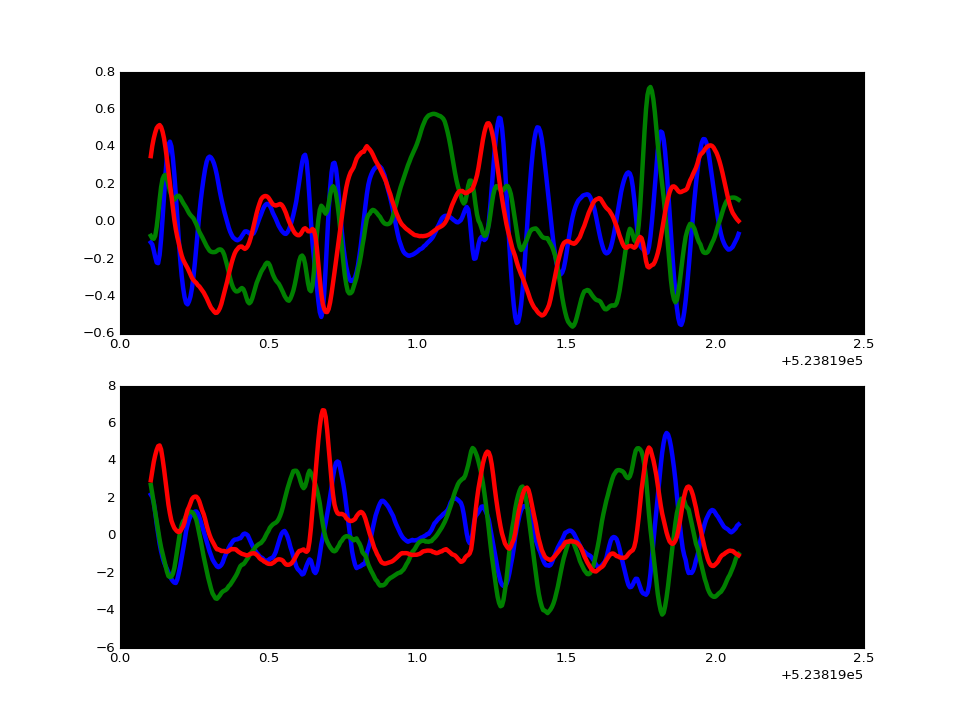

In [17]:
# inspect the feature noise. Evaluate the previous cell first!

tp = 1000
gyro = data_all[['gyro_x', 'gyro_y', 'gyro_z']].values
linacce = data_all[['linacce_x', 'linacce_y', 'linacce_z']].values

# alpha = 0.05
# gyro_filtered = td.low_pass_filter(gyro, alpha)
# linacce_filtered = td.low_pass_filter(linacce, alpha)

feature_smooth_sigma = 3.0
gyro_filtered = gaussian_filter1d(gyro, sigma=feature_smooth_sigma, axis=0)
linacce_filtered = gaussian_filter1d(linacce, sigma=feature_smooth_sigma, axis=0)

ws = 400
lw = 4.0
plt.figure('raw signal')
fig_gyro = plt.subplot(211)
fig_gyro.set_axis_bgcolor('black')
for i in range(3):
    plt.plot(time_stamp[tp:tp+ws], gyro[tp:tp+ws, i], linewidth=lw)
fig_linacce = plt.subplot(212)
fig_linacce.set_axis_bgcolor('black')
for i in range(3):
    plt.plot(time_stamp[tp:tp+ws], linacce[tp:tp+ws, i], linewidth=lw)
